# HW05: Deep Learning

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

In [438]:
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
import numpy as np

In [7]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import nltk
df = pd.read_csv('train.zip', names=["label", "title", "lead"]).assign(text="")
df.label = df.label.map({1: "world", 2: "sport", 3: "business", 4: "sci/tech"}) 
df.text = (df.title + " " + df.lead).str.replace("\\", " ", regex=False)
df.head()

,label,title,lead,text
0,business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [8]:
## create a new variable "business" that takes value 1 if the label is business and 0 otherwise
df = df.assign(business=(df.label == "business"))
print("Fraction of 'business' texts:", df.business.mean())

Fraction of 'business' texts: 0.25


In [92]:
dfs = df.sample(axis=0, frac=0.1, random_state=43)

In [93]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    return [w.lemma_.lower() for w in nlp(text) if not (w.is_stop or w.is_punct or w.is_digit)]

dfs['tokenized'] = dfs.text.apply(tokenize)
dfs['words'] = dfs.tokenized.apply(' '.join)

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=9999).fit(dfs.words)

## MLP

Your goal here is to use features from the Vectorized text to predict whether the snippet is from a business article.

In [156]:
#https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent

def as_sparse_tensor(words):
    coo = cv.transform(words).tocoo()
    indices = np.mat([coo.row, coo.col]).T
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))
    #np.allclose(X.todense(), tf.sparse.to_dense(X0))

In [157]:
# from tf.keras.models import Sequential
# from tf.keras.layers import Dense, Dropout
# from tf.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
(dfs_train, dfs_valid) = train_test_split(dfs, test_size=0.1, random_state=43)


In [158]:
print(len(dfs_train), len(dfs_valid))

10800 1200


In [160]:
as_sparse_tensor(dfs_train.words).shape, as_sparse_tensor(dfs_valid.words).shape

(TensorShape([10800, 9999]), TensorShape([1200, 9999]))

In [471]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

X_train = as_sparse_tensor(dfs_train.words)
y_train = tf.convert_to_tensor(dfs_train.business)
X_valid = as_sparse_tensor(dfs_valid.words)
y_valid = tf.convert_to_tensor(dfs_valid.business)
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)])

Epoch 1/10
338/338 [==============================] - 1s 2ms/step - loss: 0.5903 - accuracy: 0.7330 - val_loss: 0.2929 - val_accuracy: 0.7583
Epoch 2/10
338/338 [==============================] - 1s 2ms/step - loss: 0.2651 - accuracy: 0.8062 - val_loss: 0.2566 - val_accuracy: 0.9250
Epoch 3/10
338/338 [==============================] - 1s 2ms/step - loss: 0.2044 - accuracy: 0.9610 - val_loss: 0.2367 - val_accuracy: 0.9375
Epoch 4/10
338/338 [==============================] - 1s 2ms/step - loss: 0.1559 - accuracy: 0.9744 - val_loss: 0.2353 - val_accuracy: 0.9350
Epoch 5/10
338/338 [==============================] - 1s 2ms/step - loss: 0.1291 - accuracy: 0.9803 - val_loss: 0.2355 - val_accuracy: 0.9342


In [473]:
from sklearn.metrics import roc_curve, auc
(fpr_cv, tpr_cv, _) = roc_curve(dfs_valid.business, model(as_sparse_tensor(dfs_valid.words)))

## Autoencoders

In [307]:
tf.sparse.reduce_sum(X_train, axis=-1)

<tf.Tensor: shape=(10800,), dtype=int64, numpy=array([24, 28, 27, ..., 13, 32, 25])>

In [447]:
def R2(y_true, y_pred):
    ss_res = tf.reduce_sum((y_true - y_pred) ** 2, axis=-1) 
    ss_tot = tf.reduce_sum((y_true - tf.reduce_mean(y_true, axis=-1, keepdims=True)) ** 2, axis=-1) 
    return (1 - tf.math.divide_no_nan(ss_res, ss_tot))

## build a simple autoencoder with two compression layers and two reconstruction layers using ReLu
## compile and fit the model minimizing "mean_squared_error"
## report r_squared during training (the function r2 defined above)

encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[len(cv.get_feature_names())]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(cv.get_feature_names()), activation='relu'),
])

model = tf.keras.Sequential([encoder, decoder])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', R2]
    #metrics=[R2],
)

ds_train = tf.data.Dataset.from_tensor_slices(X_train).map(tf.sparse.to_dense).map(lambda x: tf.cast(x, dtype=tf.float32))
ds_valid = tf.data.Dataset.from_tensor_slices(X_valid).map(tf.sparse.to_dense).map(lambda x: tf.cast(x, dtype=tf.float32))

model.fit(
    x=tf.data.Dataset.zip((ds_train, ds_train)).batch(32),
    verbose=1,
    steps_per_epoch=None,
    epochs=20,
    validation_data=tf.data.Dataset.zip((ds_valid, ds_valid)).batch(32),
)

# Mean squared error appears quite small because of sparsity (and the square)
# The R2 goes over 0.2 with some simple net architectures but not much further

Epoch 1/20
338/338 [==============================] - 6s 16ms/step - loss: 0.0030 - accuracy: 0.0493 - R2: 0.0182 - val_loss: 0.0028 - val_accuracy: 0.1492 - val_R2: 0.0708
Epoch 2/20
338/338 [==============================] - 5s 15ms/step - loss: 0.0028 - accuracy: 0.1441 - R2: 0.0803 - val_loss: 0.0027 - val_accuracy: 0.1542 - val_R2: 0.0983
Epoch 3/20
338/338 [==============================] - 5s 15ms/step - loss: 0.0027 - accuracy: 0.1628 - R2: 0.1046 - val_loss: 0.0027 - val_accuracy: 0.1925 - val_R2: 0.1102
Epoch 4/20
338/338 [==============================] - 5s 16ms/step - loss: 0.0027 - accuracy: 0.1774 - R2: 0.1197 - val_loss: 0.0027 - val_accuracy: 0.2017 - val_R2: 0.1171
Epoch 5/20
338/338 [==============================] - 5s 16ms/step - loss: 0.0027 - accuracy: 0.1907 - R2: 0.1310 - val_loss: 0.0027 - val_accuracy: 0.2108 - val_R2: 0.1181
Epoch 6/20
338/338 [==============================] - 6s 16ms/step - loss: 0.0026 - accuracy: 0.2035 - R2: 0.1398 - val_loss: 0.0027 - 

In [365]:
## compress the vectorized text (X.todense())

compressed = pd.DataFrame(data=encoder(as_sparse_tensor(dfs.words)).numpy(), index=dfs.index)

# For fun, let's look at similar texts
from sklearn.neighbors import KDTree
tree = KDTree(compressed.values, leaf_size=3)

In [362]:
# A case where it works
([dist], [idx]) = tree.query(compressed.sample(1, random_state=43), k=3)
print("### Three neighbors:")
print(*list(dfs.iloc[idx].text), sep='\n')

print("### Three random:")
print(*list(dfs.sample(3, random_state=43).text), sep='\n')

### Three neighbors:
Dollar Extends Recovery Against Euro, Yen  TOKYO (Reuters) - The dollar rebounded for a second session  on Thursday as traders and investors took profits on bets  against the U.S. currency before the year draws to a close.
Dollar Inches Up  TOKYO (Reuters) - The dollar edged up against the euro on  Tuesday, expanding the previous day's gains as traders took  stern words from European officials against the U.S. currency's  weakness as a signal to take profits.
Dollar Vulnerable, Stocks Rise Overseas  LONDON (Reuters) - The euro was near two-month highs  against the dollar Friday as key U.S. data loomed and as  traders awaited a Group of Seven meeting of finance ministers,  while oil-fired inflation fears lifted gold close.
### Three random:
Dollar Extends Recovery Against Euro, Yen  TOKYO (Reuters) - The dollar rebounded for a second session  on Thursday as traders and investors took profits on bets  against the U.S. currency before the year draws to a close.
A majo

In [361]:
# A case where it doesn't really work (different random_state)
([dist], [idx]) = tree.query(compressed.sample(1, random_state=11), k=3)
print("### Three neighbors:")
print(*list(dfs.iloc[idx].text), sep='\n')

print("### Three random:")
print(*list(dfs.sample(3, random_state=11).text), sep='\n')

### Three neighbors:
Software Tutors Offer Help and Customized Hints OURTEEN-year-old Rochelle Brown was close to solving an algebra problem. Yet she stumbled repeatedly on one calculation: -2.3  .5.
Loss of face Mitsubishi Motors, damaged by a series of cover-ups over vehicle defects, yesterday produced the worst results in its 34-year history, with interim net losses doubling to 146 billion yen (744m).
Pension Promise No Guarantee of Security With just eight years to go, Steve Derebey had been eyeing his mandatory retirement age with something close to relief.
### Three random:
Software Tutors Offer Help and Customized Hints OURTEEN-year-old Rochelle Brown was close to solving an algebra problem. Yet she stumbled repeatedly on one calculation: -2.3  .5.
Pollution May Be Reducing Calif. Rainfall (AP) AP - Urban air pollution may be reducing rainfall in the Central Valley and along the heavily populated southern California coast, while trimming mountain snowfall that supplies much of t

## Embeddings

In [385]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence

print(text_to_word_sequence("T hkj khjahkjs . asd as"))

dfs['ktokens'] = dfs.text.apply(text_to_word_sequence)

dfs.head(2)

['t', 'hkj', 'khjahkjs', 'asd', 'as']


,label,title,lead,text,business,tokenized,words,ktokens
8711,world,British Theater Reaches Out to Autistic Childr...,"Reuters - For children with autism, theater ca...",British Theater Reaches Out to Autistic Childr...,False,"[british, theater, reach, autistic, children, ...",british theater reach autistic children reuter...,"[british, theater, reaches, out, to, autistic,..."
38069,business,European Shares Dip on Swiss Re Woes (Reuters),Reuters - Swiss Re led European shares lower o...,European Shares Dip on Swiss Re Woes (Reuters)...,True,"[european, shares, dip, swiss, woe, reuters, r...",european shares dip swiss woe reuters reuters ...,"[european, shares, dip, on, swiss, re, woes, r..."


In [478]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

length_vocab = 1000
max_seq_length = 100

from more_itertools import first

#print(*one_hot(first(dfs.text), n=1000))

# create a one_hot representation for each word and truncate/pad the sequences such that they are all of the same length

A_train = pad_sequences(dfs_train.text.apply(lambda t: one_hot(t, n=length_vocab)), maxlen=max_seq_length)
A_valid = pad_sequences(dfs_valid.text.apply(lambda t: one_hot(t, n=length_vocab)), maxlen=max_seq_length)

print((A_train.shape))
print(*A_train[0, :])

(10800, 100)
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 859 577 287 651 291 8 428 375 329 301 859 577 628 632 143 884 275 68 917 303 863 751 446 902 94 428 953 375 443 187 734 14 8 143 10 143 830 859 209


In [479]:
from tensorflow.keras.layers import Embedding

# create a sequential model with just one embedding layer and show the model summary

model = tf.keras.models.Sequential([Embedding(input_dim=length_vocab, output_dim=32, )])
model(A_train).shape

model.summary()

Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 32)          32000     
Total params: 32,000
Trainable params: 32,000
Non-trainable params: 0
_________________________________________________________________


## LSTM

In [487]:
# create a sequential model with an embedding layer, a LSTM layer and two hidden layers with ReLu activation function, followed by dropout

model = tf.keras.models.Sequential([
    Embedding(input_dim=length_vocab, output_dim=16),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model(A_train).shape

TensorShape([10800, 1])

In [488]:
model.fit(x=A_train, y=dfs_train.business, epochs=10, validation_data=(A_valid, dfs_valid.business), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
338/338 [==============================] - 16s 42ms/step - loss: 0.5262 - accuracy: 0.7656 - val_loss: 0.3508 - val_accuracy: 0.8492
Epoch 2/10
338/338 [==============================] - 13s 37ms/step - loss: 0.3044 - accuracy: 0.8831 - val_loss: 0.3273 - val_accuracy: 0.8583
Epoch 3/10
338/338 [==============================] - 12s 36ms/step - loss: 0.2991 - accuracy: 0.8869 - val_loss: 0.3318 - val_accuracy: 0.8658
Epoch 4/10
338/338 [==============================] - 12s 35ms/step - loss: 0.2628 - accuracy: 0.9032 - val_loss: 0.3216 - val_accuracy: 0.8625
Epoch 5/10
338/338 [==============================] - 13s 40ms/step - loss: 0.2514 - accuracy: 0.9062 - val_loss: 0.3296 - val_accuracy: 0.8675
Epoch 6/10
338/338 [==============================] - 12s 35ms/step - loss: 0.2358 - accuracy: 0.9131 - val_loss: 0.3300 - val_accuracy: 0.8583
Epoch 7/10
338/338 [==============================] - 12s 35ms/step - loss: 0.2177 - accuracy: 0.9214 - val_loss: 0.3573 - val_accuracy:

In [489]:
from sklearn.metrics import roc_curve, auc
(fpr_lstm, tpr_lstm, _) = roc_curve(dfs_valid.business, model(A_valid))

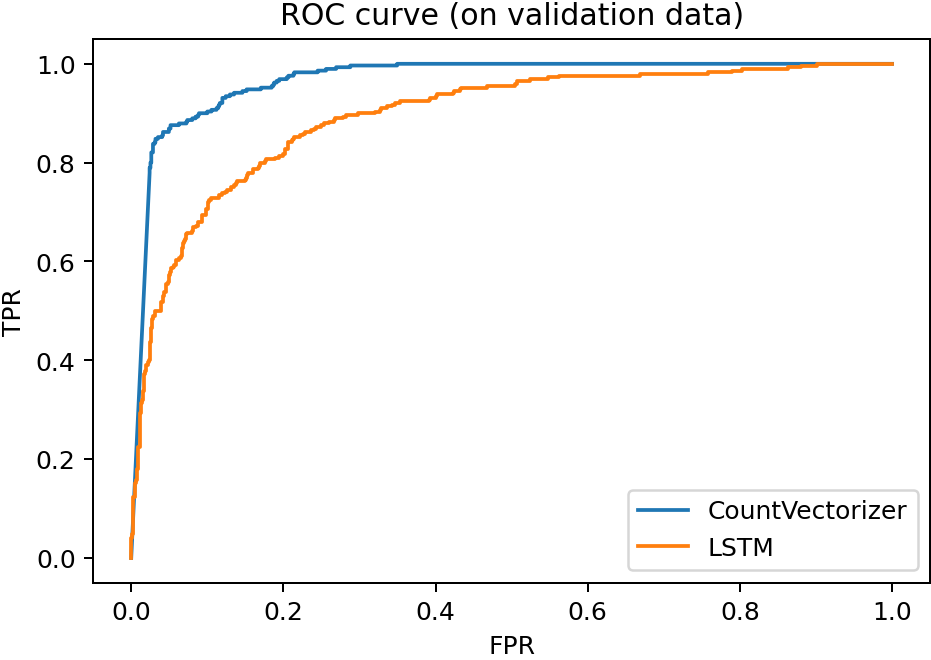

In [490]:
from plox import Plox
with Plox() as px:
    px.a.plot(fpr_cv, tpr_cv, '-', label="CountVectorizer")
    px.a.plot(fpr_lstm, tpr_lstm, '-', label="LSTM")
    px.a.set_xlabel("FPR")
    px.a.set_ylabel("TPR")
    px.a.set_title("ROC curve (on validation data)")
    px.a.legend()
    px.show()